In [1]:
! pip install thop
! pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter


2025-07-12 07:13:08.662884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752304388.890153      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752304388.951210      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

In [4]:
#檢查是否可用gpu
print(torch.cuda.is_available())

True


In [5]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

100%|██████████| 170M/170M [00:02<00:00, 57.8MB/s]


[0.49209866 0.4825856  0.44549522] [0.24632068 0.24276644 0.26065928]
[0.49209866 0.4825856  0.44549522] [0.24632068 0.24276644 0.26065928]


In [6]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    transforms.ToTensor(),

    # data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [7]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
image, label = trainset[0]
print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# 宣告 batch size
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

image shape:  torch.Size([3, 32, 32])
train length:  45000
val length:  5000
test length:  10000


# Task 1
1. 搭建由{CNN,BN,ReLU}所組成的layer
2. 用兩層layer搭配pooling layer 和 FC layer創建出model
3. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [8]:
import torch.nn.functional as F

#####   create your own model   #####
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(256 * 8 * 8, 10)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)   # flatten
        out = self.fc(out)
        return out



In [9]:
##### setting parameter #####
EPOCH = 40
pre_epoch = 0
lr = 0.001
device = torch.device("cuda")

In [10]:
from thop import profile
from torchsummary import summary

# 宣告model
model = SimpleCNN().to(device)
summary(model, (3, 32, 32))

##### 使用 thop 計算 FLOPs 和參數數量 #####
input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
       BatchNorm2d-9          [-1, 256, 16, 16]             512
             ReLU-10          [-1, 256, 16, 16]               0
        MaxPool2d-11            [-1, 256, 8, 8]               0
          Dropout-12            [-1, 256, 8, 8]               0
           Linear-13                   [-1, 10]         163,850
Total params: 535,562
Trainable params:

In [11]:
# ##### Train model #####

patience = 10
trigger_time = 0
min_improvement = 1.0

# 初始化模型損失函數與優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH)

# 設定參數
best_model_path = 'best_model.pth'  # 模型保存路徑
best_accuracy = 0.0  # 最佳準確率

# 用於記錄 loss 和 accuracy 的列表
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 訓練模型
for epoch in range(pre_epoch, EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 初始化梯度
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 反向傳播與優化
        loss.backward()
        optimizer.step()

        # 累積損失
        running_loss += loss.item()

        # 計算訓練準確率
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100. * correct / total

    # 記錄訓練損失和準確率
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 驗證模型
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(valloader)
    val_accuracy = 100. * correct / total

    # 記錄驗證損失和準確率
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    print(f'Epoch {epoch+1}/{EPOCH}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > best_accuracy and (val_accuracy - best_accuracy) >= min_improvement:
        best_accuracy = val_accuracy
        trigger_time = 0
        torch.save(model.state_dict(), best_model_path)
        print('Saving best model with accuracy {:.2f}%'.format(best_accuracy))
    else:
        trigger_time += 1
        if trigger_time >= patience:
            print(f'Early stopping at epoch {epoch+1} with best accuracy: {best_accuracy:.2f}%')
            break

print('Finished Training')

Epoch 1/40, Train Loss: 2.3380, Train Accuracy: 32.01%, Val Loss: 1.5841, Val Accuracy: 42.40%
Saving best model with accuracy 42.40%
Epoch 2/40, Train Loss: 1.5138, Train Accuracy: 45.76%, Val Loss: 1.4109, Val Accuracy: 48.52%
Saving best model with accuracy 48.52%
Epoch 3/40, Train Loss: 1.3104, Train Accuracy: 53.27%, Val Loss: 1.3144, Val Accuracy: 53.24%
Saving best model with accuracy 53.24%
Epoch 4/40, Train Loss: 1.1764, Train Accuracy: 57.92%, Val Loss: 1.2363, Val Accuracy: 55.24%
Saving best model with accuracy 55.24%
Epoch 5/40, Train Loss: 1.0925, Train Accuracy: 61.38%, Val Loss: 1.0292, Val Accuracy: 63.40%
Saving best model with accuracy 63.40%
Epoch 6/40, Train Loss: 1.0257, Train Accuracy: 63.91%, Val Loss: 1.0301, Val Accuracy: 64.04%
Epoch 7/40, Train Loss: 0.9745, Train Accuracy: 65.79%, Val Loss: 1.0145, Val Accuracy: 65.32%
Saving best model with accuracy 65.32%
Epoch 8/40, Train Loss: 0.9383, Train Accuracy: 66.93%, Val Loss: 0.8999, Val Accuracy: 68.78%
Saving

In [12]:
# # load 你的best model再跑一次testloader
model.load_state_dict(torch.load(best_model_path))
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss = test_loss / len(testloader)
test_accuracy = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.4304, Test Accuracy: 85.48%


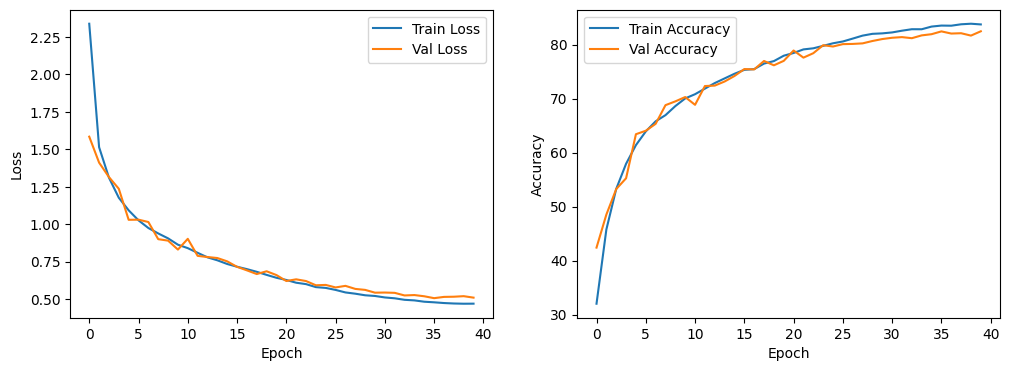

In [13]:
import matplotlib.pyplot as plt

# ##### 繪製 loss 和 accuracy 的圖 #####
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Task 2
1. 完成resnet18.py並上傳
2. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [14]:
from thop import profile
import sys
sys.path.append('/kaggle/input/resnet/pytorch/default/1')
from resnet18 import *
##### 使用 thop 計算 FLOPs 和參數數量 #####
# 宣告model
model = ResNet(ResBlock).to(device)
summary(model, (3, 32, 32))

input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
          ResBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [15]:
# setting parameter
EPOCH = 50
pre_epoch = 0
lr = 0.001

In [16]:
#引用resnet.18
net = ResNet(ResBlock).to(device)

##### Train model #####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

acc_list, loss_list = [], []
val_acc_list, val_loss_list = [], []

for epoch in range(pre_epoch, EPOCH):
    print(f'\n[epoch:{epoch + 1}]')
    net.train()
    sum_loss, correct, total = 0.0, 0.0, 0.0

    for i, data in enumerate(trainloader, 0):
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

    print(f"Loss: {sum_loss / (i + 1):.3f} | Acc: {100. * correct / total:.3f} %")

    loss_list.append(sum_loss / (i + 1))
    acc_list.append(100. * correct / total)

    # Validation
    with torch.no_grad():
        correct, total = 0.0, 0.0
        sum_val_loss = 0.0
        net.eval()
        for j, val_data in enumerate(valloader, 0):
            val_images, val_labels = val_data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            
            val_outputs = net(val_images)
            val_loss = criterion(val_outputs, val_labels)
            
            sum_val_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (val_predicted == val_labels).sum().item()

        print(f"val_Loss: {sum_val_loss / (j + 1):.3f} | val_Acc: {100. * correct / total:.3f} %")

        val_loss_list.append(sum_val_loss / (j + 1))
        val_acc_list.append(100. * correct / total)

    scheduler.step()

print("Training Finished.")


[epoch:1]
Loss: 1.519 | Acc: 44.116 %
val_Loss: 1.409 | val_Acc: 49.540 %

[epoch:2]
Loss: 1.108 | Acc: 60.516 %
val_Loss: 1.042 | val_Acc: 62.920 %

[epoch:3]
Loss: 0.939 | Acc: 66.991 %
val_Loss: 1.095 | val_Acc: 60.100 %

[epoch:4]
Loss: 0.814 | Acc: 71.471 %
val_Loss: 1.298 | val_Acc: 57.760 %

[epoch:5]
Loss: 0.751 | Acc: 73.864 %
val_Loss: 0.753 | val_Acc: 73.680 %

[epoch:6]
Loss: 0.683 | Acc: 76.391 %
val_Loss: 0.739 | val_Acc: 73.960 %

[epoch:7]
Loss: 0.641 | Acc: 78.007 %
val_Loss: 0.751 | val_Acc: 73.820 %

[epoch:8]
Loss: 0.607 | Acc: 79.231 %
val_Loss: 0.924 | val_Acc: 70.240 %

[epoch:9]
Loss: 0.568 | Acc: 80.291 %
val_Loss: 0.959 | val_Acc: 69.400 %

[epoch:10]
Loss: 0.542 | Acc: 81.231 %
val_Loss: 0.685 | val_Acc: 76.960 %

[epoch:11]
Loss: 0.517 | Acc: 82.182 %
val_Loss: 0.626 | val_Acc: 78.540 %

[epoch:12]
Loss: 0.500 | Acc: 82.962 %
val_Loss: 0.638 | val_Acc: 78.300 %

[epoch:13]
Loss: 0.477 | Acc: 83.644 %
val_Loss: 0.539 | val_Acc: 81.860 %

[epoch:14]
Loss: 0.4

In [17]:
# 測試模型在測試集上的表現
with torch.no_grad():
    correct = 0.0
    total = 0.0
    net.eval()  # 切換到評估模式
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.3f} %")

Test Accuracy: 88.350 %


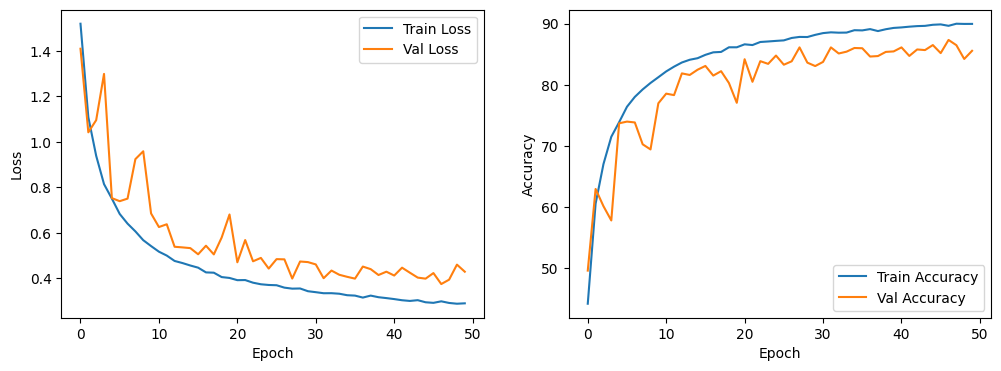

In [18]:
##### 繪製 loss 和 accuracy 的圖 #####
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()